# **Phase 1: Deep Learning Model Development**

**Step 1: Setup Environment and Download Data**

In [1]:
# Install required packages
!pip install kaggle tensorflow opencv-python matplotlib seaborn numpy scikit-learn

# Setup Kaggle (you'll need to upload your kaggle.json)
from google.colab import files
files.upload()  # Upload your kaggle.json file

# Create directory and set permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip -q intel-image-classification.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 94% 325M/346M [00:00<00:00, 480MB/s]
100% 346M/346M [00:00<00:00, 541MB/s]


**Step 2: Exploratory Data Analysis (EDA)**

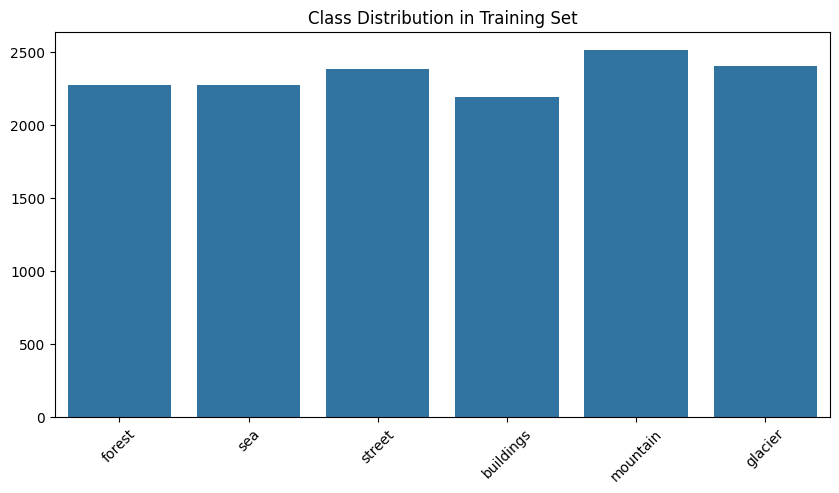

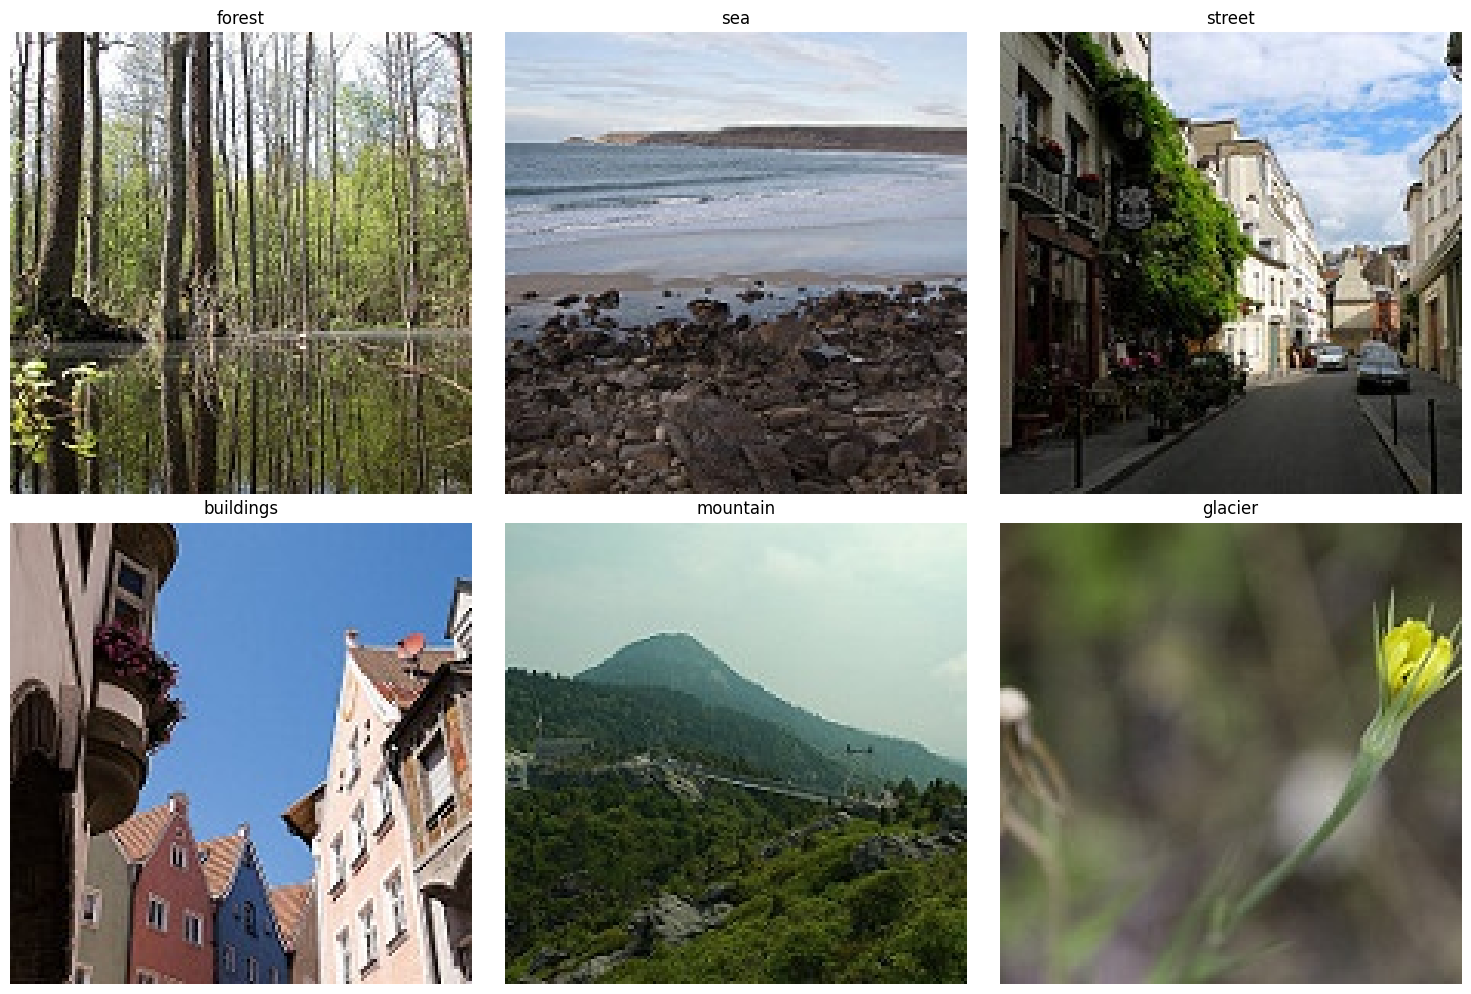

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Set paths
train_path = '/content/seg_train/seg_train'
test_path = '/content/seg_test/seg_test'

# Check class distribution
class_names = os.listdir(train_path)
class_counts = {class_name: len(os.listdir(os.path.join(train_path, class_name)))
                for class_name in class_names}

plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=45)
plt.show()

# Display sample images from each class
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, class_name in enumerate(class_names):
    img_path = os.path.join(train_path, class_name, os.listdir(os.path.join(train_path, class_name))[0])
    img = load_img(img_path)
    axes[i//3, i%3].imshow(img)
    axes[i//3, i%3].set_title(class_name)
    axes[i//3, i%3].axis('off')
plt.tight_layout()
plt.show()

**Step 3: Data Preprocessing and Augmentation**

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/seg_train/seg_train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '/content/seg_train/seg_train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    '/content/seg_test/seg_test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Class names
class_names = list(train_generator.class_indices.keys())

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


**Step 4: Build and Train Custom CNN**

In [4]:
# Custom CNN model
def create_custom_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(6, activation='softmax')
    ])
    return model

custom_model = create_custom_cnn()
custom_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train custom model
history_custom = custom_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stop]
)

# Save custom model
custom_model.save('custom_cnn_model.h5')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 109s 279ms/step - accuracy: 0.3838 - loss: 3.5143 - val_accuracy: 0.3973 - val_loss: 1.5300 - learning_rate: 0.0010
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 84s 239ms/step - accuracy: 0.5482 - loss: 1.1991 - val_accuracy: 0.4661 - val_loss: 1.2303 - learning_rate: 0.0010
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 88s 250ms/step - accuracy: 0.6168 - loss: 1.0327 - val_accuracy: 0.6976 - val_loss: 0.8845 - learning_rate: 0.0010
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 88s 251ms/step - accuracy: 0.6561 - loss: 0.9359 - val_accuracy: 0.4982 - val_loss: 1.3994 - learning_rate: 0.0010
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 238ms/step - accuracy: 0.6757 - loss: 0.8754 - val_accuracy: 0.6947 - val_loss: 0.8455 - learning_rate: 0.0010
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 143s 240ms/step - accuracy: 0.7079 - loss: 0.8271 - val_accuracy: 0.5621 - val_loss: 1.1561 - learning_rate: 0.0010
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 85s 242ms/step - accuracy: 0

**Step 5: Build and Train Transfer Learning Model**

In [5]:
# Transfer learning with EfficientNetB0
def create_transfer_model():
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
    base_model.trainable = False  # Freeze base model

    inputs = tf.keras.Input(shape=(150, 150, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(6, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model, base_model

transfer_model, base_model = create_transfer_model()
transfer_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Train transfer model
history_transfer = transfer_model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stop]
)

# Fine-tuning: Unfreeze some layers
base_model.trainable = True
# Freeze first 100 layers
for layer in base_model.layers[:100]:
    layer.trainable = False

transfer_model.compile(optimizer=Adam(learning_rate=1e-5),  # Low learning rate
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

history_fine_tune = transfer_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# Save transfer model
transfer_model.save('transfer_model.h5')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 148s 346ms/step - accuracy: 0.1650 - loss: 1.8205 - val_accuracy: 0.1619 - val_loss: 1.8162 - learning_rate: 0.0010
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 238ms/step - accuracy: 0.1709 - loss: 1.8085 - val_accuracy: 0.1765 - val_loss: 1.7888 - learning_rate: 0.0010
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 84s 238ms/step - accuracy: 0.1780 - loss: 1.8054 - val_accuracy: 0.2564 - val_loss: 1.7892 - learning_rate: 0.0010
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 237ms/step - accuracy: 0.1769 - loss: 1.8059 - val_accuracy: 0.1712 - val_loss: 1.7949 - learning_rate: 0.0010
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 82s 233ms/step - accuracy: 0.1915 - loss: 1.7949 - val_accuracy: 0.1698 - val_loss: 1.7863 - learning_rate: 0.0010
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 236ms/step - accuracy: 0.1903 - loss: 1.7929 - val_accuracy: 0.1994 - val_loss: 1.8073 - learning_rate: 0.0010
Epoch 7/30
351/351

**Step 6: Model Evaluation**

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9000 - loss: 0.2896
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 0.4181 - loss: 1.7533
Custom CNN - Test Accuracy: 0.8823
Transfer Learning - Test Accuracy: 0.1457
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step


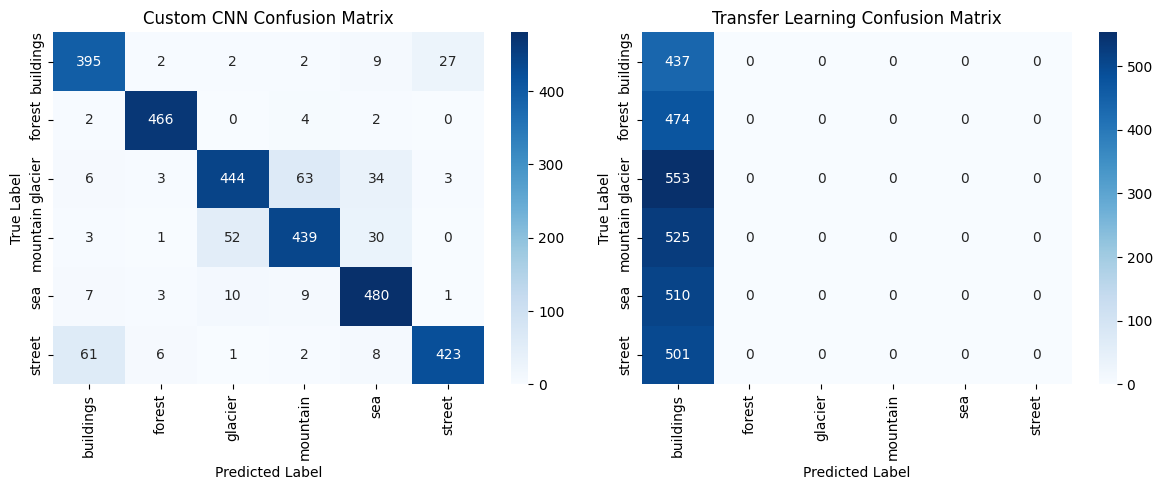

Custom CNN Classification Report:
              precision    recall  f1-score   support

   buildings       0.83      0.90      0.87       437
      forest       0.97      0.98      0.98       474
     glacier       0.87      0.80      0.84       553
    mountain       0.85      0.84      0.84       525
         sea       0.85      0.94      0.89       510
      street       0.93      0.84      0.89       501

    accuracy                           0.88      3000
   macro avg       0.88      0.89      0.88      3000
weighted avg       0.88      0.88      0.88      3000

Transfer Learning Classification Report:
              precision    recall  f1-score   support

   buildings       0.15      1.00      0.25       437
      forest       0.00      0.00      0.00       474
     glacier       0.00      0.00      0.00       553
    mountain       0.00      0.00      0.00       525
         sea       0.00      0.00      0.00       510
      street       0.00      0.00      0.00       501

  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


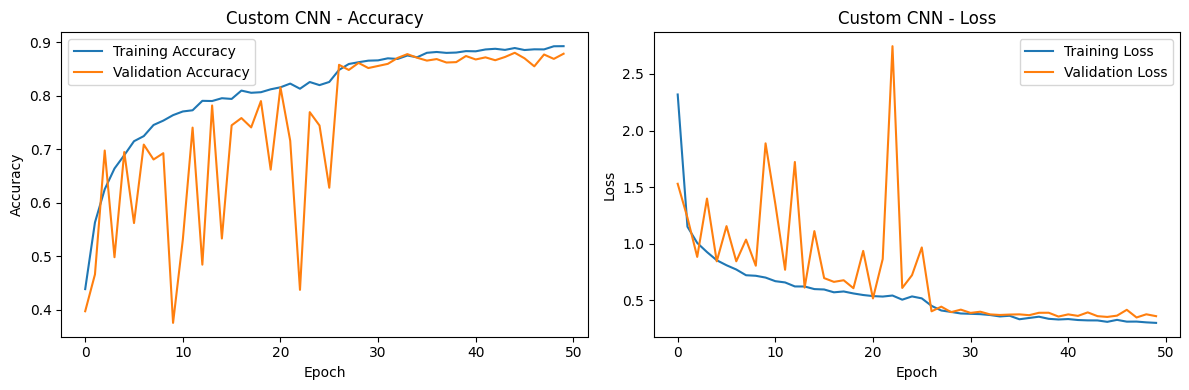

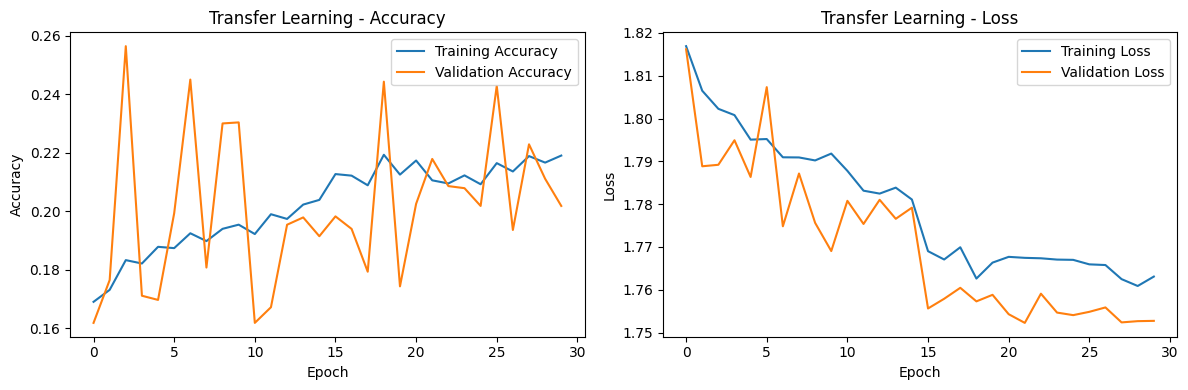

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load models
custom_model = tf.keras.models.load_model('custom_cnn_model.h5')
transfer_model = tf.keras.models.load_model('transfer_model.h5')

# Evaluate models
custom_loss, custom_accuracy = custom_model.evaluate(test_generator)
transfer_loss, transfer_accuracy = transfer_model.evaluate(test_generator)

print(f"Custom CNN - Test Accuracy: {custom_accuracy:.4f}")
print(f"Transfer Learning - Test Accuracy: {transfer_accuracy:.4f}")

# Predictions for confusion matrix
test_generator.reset()
y_true = test_generator.classes
y_pred_custom = custom_model.predict(test_generator)
y_pred_transfer = transfer_model.predict(test_generator)

y_pred_custom_classes = np.argmax(y_pred_custom, axis=1)
y_pred_transfer_classes = np.argmax(y_pred_transfer, axis=1)

# Confusion matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm_custom = confusion_matrix(y_true, y_pred_custom_classes)
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Custom CNN Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.subplot(1, 2, 2)
cm_transfer = confusion_matrix(y_true, y_pred_transfer_classes)
sns.heatmap(cm_transfer, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Transfer Learning Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Classification reports
print("Custom CNN Classification Report:")
print(classification_report(y_true, y_pred_custom_classes, target_names=class_names))

print("Transfer Learning Classification Report:")
print(classification_report(y_true, y_pred_transfer_classes, target_names=class_names))

# Plot training history
def plot_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{title} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_custom, 'Custom CNN')
plot_history(history_transfer, 'Transfer Learning')

# **Phase 2: Multi-Modal Integration**

**Step 7: Uncertainty Estimation and LLM Integration**

In [9]:
import numpy as np
import openai
import os
import requests
from PIL import Image
import tensorflow as tf

# Monte Carlo Dropout for uncertainty estimation
def predict_with_uncertainty(model, image, n_iter=50):
    """
    Make predictions with Monte Carlo Dropout for uncertainty estimation
    """
    # Enable dropout at test time
    predictions = np.stack([model(image, training=True) for _ in range(n_iter)])
    mean_prediction = np.mean(predictions, axis=0)
    uncertainty = np.std(predictions, axis=0)

    predicted_class = np.argmax(mean_prediction, axis=1)[0]
    confidence = mean_prediction[0, predicted_class]
    uncertainty_score = uncertainty[0, predicted_class]

    return predicted_class, confidence, uncertainty_score

# LLM integration for scene description
def generate_scene_description(predicted_class, api_key):
    """
    Generate a scene description using OpenAI API
    """
    openai.api_key = api_key

    prompt = f"""Generate a very short, single-sentence description of a {predicted_class} scene,
    suitable for an alt-text. Do not use the word 'image' or 'photo'. Description:"""

    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant that generates concise image descriptions."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=30,
            temperature=0.7
        )
        return response.choices[0].message['content'].strip()
    except Exception as e:
        print(f"Error calling OpenAI API: {e}")
        # Fallback descriptions
        fallback_descriptions = {
            'buildings': 'A cityscape with tall structures and architectural details.',
            'forest': 'A dense woodland with various trees and vegetation.',
            'glacier': 'A vast icy landscape with snow-covered formations.',
            'mountain': 'Majestic peaks rising against the sky.',
            'sea': 'Expansive body of water with waves and horizon.',
            'street': 'Urban pathway with buildings and potential activity.'
        }
        return fallback_descriptions.get(predicted_class, 'A natural scene.')

# Image preprocessing
def preprocess_image(image_path, target_size=(150, 150)):
    """
    Preprocess image for model prediction
    """
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    return img_array

In [10]:
# In your Colab notebook, download the trained models
from google.colab import files

files.download('transfer_model.h5')  # Download your best model
files.download('custom_cnn_model.h5')  # Download your custom model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>